In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%cd ..

userData = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
nonBorrower = pd.read_csv('non_borrower_user.csv')
loan = pd.read_csv('loan_activities.csv')

c:\Users\Adli\Desktop\ilegil\bintangkecilmama\DATATHON


In [3]:
trainLoan = userData.set_index('user_id').join(loan.set_index('user_id')).reset_index() #nyatuin data train sama loan
trainLoan = trainLoan.drop('pc8', axis=1) #drop kolom yang sama menurut heatmap
trainLoan = trainLoan.drop('pc9', axis=1) #drop kolom yang sama menurut heatmap
userData['-1_count'] = userData.isin([-1]).sum(axis=1) #nambahin kolom missing values (-1)
userData['is_loanreference'] = userData['user_id'].isin(loan["reference_contact"]) #nambahin kolom apakah usernya dijadiin loan reference
userData["has_borrowed"] = userData["user_id"].isin(loan["user_id"]) #nambahin kolom apakah usernya pernah minjem

nonLoan = nonBorrower.set_index('user_id').join(loan.set_index('user_id')).reset_index()

loan["referenced_is_non"] = loan["reference_contact"].isin(nonBorrower["user_id"])
loan["referenced_is_fraud"] = loan["reference_contact"].isin(userData.loc[userData["label"] == 1]["user_id"])

In [4]:
loanFraud = trainLoan.loc[trainLoan["label"]==1]
loanFraud = loanFraud[["user_id", "reference_contact", "loan_type", "ts"]]
loanNonFraud = trainLoan.loc[trainLoan["label"]==0]
loanNonFraud = loanNonFraud[["user_id", "reference_contact", "loan_type", "ts"]]

In [5]:
referenceInfo = pd.DataFrame()
referenceInfo["user_id"] = pd.concat([userData["user_id"], (nonBorrower["user_id"])])
referenceInfo["referenced_by_fraud"] = referenceInfo["user_id"].isin(loanFraud["reference_contact"])
referenceInfo["referenced_by_non"] = referenceInfo["user_id"].isin(loan.loc[loan.user_id.isin(nonBorrower.user_id)]["reference_contact"])
referenceInfo["referencing_fraud"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_fraud"] == 1]["user_id"])
referenceInfo["referencing_non"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_non"] == 1]["user_id"])
referenceInfo["label"] = referenceInfo["user_id"].isin(userData.loc[userData["label"] == 1]["user_id"])
referenceInfo.loc[referenceInfo['user_id'].isin(nonBorrower["user_id"])]['label'] = None

C:\Users\Adli\AppData\Local\Temp\ipykernel_18988\3987793918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  referenceInfo.loc[referenceInfo['user_id'].isin(nonBorrower["user_id"])]['label'] = None


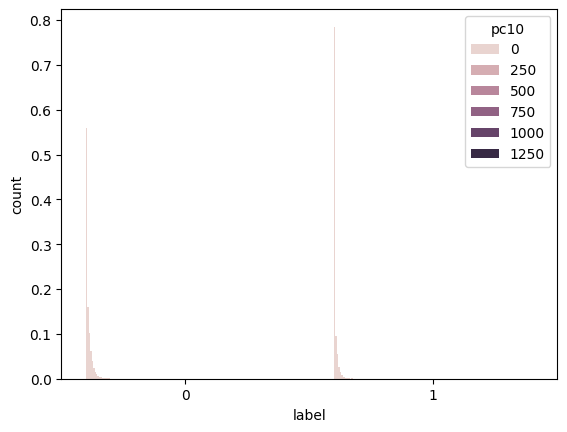

In [6]:
def categoricalAnalysis(attribute) :
    temp = userData.groupby([attribute, "label"]).count()["user_id"].reset_index()
    temp.rename(columns={"user_id" : "count"}, inplace=True)
    temp["count"] = temp.groupby([attribute], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

    sns.barplot(data= temp, x=attribute, hue="label", y= "count")
    plt.show()

def analysisCategorical(attribute) :
    temp = userData.groupby([attribute, "label"]).count()["user_id"].reset_index()
    temp.rename(columns={"user_id" : "count"}, inplace=True)
    temp["count"] = temp.groupby(["label"], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

    sns.barplot(data= temp, x="label", hue=attribute, y= "count")
    plt.show()

attribute = "pc10"
temp = userData.groupby([attribute, "label"]).count()["user_id"].reset_index()
temp.rename(columns={"user_id" : "count"}, inplace=True)
temp["count"] = temp.groupby([attribute], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

analysisCategorical("pc10")

In [7]:
# cm = pd.crosstab(y_test.values, predict, rownames=['Actual'], colnames=['Predicted'])
# fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
# sns.heatmap(cm, 
#             xticklabels=['Not Fraud', 'Fraud'],
#             yticklabels=['Not Fraud', 'Fraud'],
#             annot=True,ax=ax1,
#             linewidths=.2,linecolor="Darkblue", cmap="Blues")
# plt.title('Confusion Matrix', fontsize=14)
# plt.show()

**KESIMPULAN**
- test ada yang minjem ada yang ga pernah minjem
- test ada yang direference dan ada yang ga pernah direference
- user yang direference oleh fraud belum tentu fraud
- user yang mereference fraud belum tentu fraud
- Orang yang ga minjem belum tentu non fraud

**Notes**
- label di referenceInfo dibikin -1 buat yang ada di dataframe nonBorrower

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

trainLoanReference = trainLoan.set_index('user_id').join(referenceInfo.set_index('user_id'), lsuffix='_train', rsuffix='_reference').reset_index() #nyatuin data train sama loan
trainLoanReference.rename(columns={"label_train" : "label"}, inplace=True)
trainLoanReference.fillna(0, inplace=True)  

# Split the data into training and testing sets
X = trainLoanReference.drop(['label'], axis = 1, errors = 'ignore')  # Replace 'target_column' with your actual target column name
y = trainLoanReference['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
# Train the model
clf.fit(X_train, y_train)

# Predict
# predict = pd.Series(clf.predict(X_test), index = X_test.index)
predict = clf.predict(X_test)

print(precision_score(y_test.values, predict))
print(recall_score(y_test.values, predict))

1.0
1.0


In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
# Train the model
clf.fit(X_train, y_train)

# Predict
# predict = pd.Series(clf.predict(X_test), index = X_test.index)
predict = clf.predict(X_test)

print(precision_score(y_test.values, predict))
print(recall_score(y_test.values, predict))

1.0
1.0


In [11]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
# Train the model
clf.fit(X_train, y_train)

# Predict
# predict = pd.Series(clf.predict(X_test), index = X_test.index)
predict = clf.predict(X_test)

print(precision_score(y_test.values, predict))
print(recall_score(y_test.values, predict))

0.0
0.0


In [12]:
# from sklearn.svm import SVC

# clf = SVC()
# # Train the model
# clf.fit(X_train, y_train)

# # Predict
# # predict = pd.Series(clf.predict(X_test), index = X_test.index)
# predict = clf.predict(X_test)

# print(precision_score(y_test.values, predict))
# print(recall_score(y_test.values, predict))